In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import transforms3d as tf3d
import matplotlib


In [2]:
mass=369 #batterie
mass+=1640-114 #corps-carton
mass/=1e3
Area=np.pi*(11.0e-02)**2
r0=11e-02
rho0=1.204
kv_motor=800.0
pwmmin=1075.0
pwmmax=1950.0
U_batt=16.8
AN=6*Area
b10=14.44

In [3]:
# %%   ####### IMPORT DATA 
print("LOADING DATA...")


log_path="./logs/copter/vol12/log_real_processed.csv"

raw_data=pd.read_csv(log_path)

print("PROCESSING DATA...")


prep_data=raw_data.drop(columns=[i for i in raw_data.keys() if (("forces" in i ) or ('pos' in i) or ("joy" in i)) ])
prep_data=prep_data.drop(columns=[i for i in raw_data.keys() if (("level" in i ) or ('Unnamed' in i) or ("index" in i)) ])
# print(prep_data)

if "vol12" in log_path:
    tmin,tmax=(-1,1e10) 
elif "vol1/" in log_path:
    tmin,tmax=(41,265) 
elif "vol2" in log_path:
    tmin,tmax=(10,140) 
    
prep_data=prep_data[prep_data['t']>tmin]
prep_data=prep_data[prep_data['t']<tmax]
prep_data=prep_data.reset_index()
for i in range(3):
    prep_data['speed_pred[%i]'%(i)]=np.r_[prep_data['speed[%i]'%(i)].values[1:len(prep_data)],0]
    
    

prep_data['dt']=np.r_[prep_data['t'].values[1:]-prep_data['t'].values[:-1],0]
prep_data['t']-=prep_data['t'][0]
prep_data=prep_data.drop(index=[0,len(prep_data)-1])




for i in range(6):
    prep_data['omega_c[%i]'%(i+1)]=(prep_data['PWM_motor[%i]'%(i+1)]-pwmmin)/(pwmmax-pwmmin)*U_batt*kv_motor*2*np.pi/60


LOADING DATA...
PROCESSING DATA...


In [33]:

# %%   ####### Identify Thrust 

def compute_single_motor_thrust_MT(c1,vak,omega,c2=0,vanilla_test=False):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)

    T=2*rho0*Area*eta*(eta-vak)

    if vanilla_test:
        T=rho0*Area*r0**2*omega**2*c1
    return T


def compute_single_motor_thrust_BET(c1,vak,omega,c2=0,vanilla_test=False):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)

    T=rho0*Area*r0*omega*(c1*r0*omega-c2*(eta-vak))
    if vanilla_test:
        T=rho0*Area*r0**2*omega**2*c1
    return T

def compute_acc_k(c1,c2=0,df=prep_data,vanilla=False,model="MT"):
    
    vak=df["speed_body[2]"]
    gamma=df["gamma[2]"]
    
    if model=="MT":
        T_sum=sum([compute_single_motor_thrust_MT(c1,vak,df['omega_c[%i]'%(i+1)],c2,vanilla_test=vanilla) for i in range(6)])
    elif model=="BET":
        T_sum=sum([compute_single_motor_thrust_BET(c1,vak,df['omega_c[%i]'%(i+1)],c2,vanilla_test=vanilla) for i in range(6)])
    else:
        return print("FIX MODEL")
    acc_k=-T_sum/mass+gamma
    
    return acc_k



def cost_vanilla(X):
    c1=X
    Y=compute_acc_k(c1,vanilla=True)
    c=np.mean((Y-prep_data['acc_body_grad[2]'])**2,axis=0)
    print("c1 :%f ,c2: VANILLA ,cost :%f"%(c1,c))
    return c

X0_vanilla=np.array([6e-6])

sol_vanilla=minimize(cost_vanilla,X0_vanilla,method="SLSQP")
c1vanilla=sol_vanilla['x']
print("\n \n")

def cost(X):
    c1,c2=X
    Y=compute_acc_k(c1,c2=c2)
    c=np.mean((Y-prep_data['acc_body_grad[2]'])**2,axis=0)
    print("c1 :%f ,c2: %f,cost :%f"%(c1,c2,c))
    return c


X0=np.zeros(2)
sol_custom=minimize(cost,X0,method="SLSQP")

c1sol,c2sol=sol_custom['x']



c1 :0.000006 ,c2: VANILLA ,cost :97.823856
c1 :0.000006 ,c2: VANILLA ,cost :97.823586
c1 :18106.892889 ,c2: VANILLA ,cost :277749637567622.125000
c1 :1810.689294 ,c2: VANILLA ,cost :2777466868391.035645
c1 :181.068935 ,c2: VANILLA ,cost :27771718042.551456
c1 :18.106899 ,c2: VANILLA ,cost :277422203.450702
c1 :1.810695 ,c2: VANILLA ,cost :2744811.498081
c1 :0.181075 ,c2: VANILLA ,cost :24594.222394
c1 :0.018113 ,c2: VANILLA ,cost :47.714021
c1 :0.018113 ,c2: VANILLA ,cost :47.714208
c1 :0.010693 ,c2: VANILLA ,cost :1.071324
c1 :0.010693 ,c2: VANILLA ,cost :1.071324

 

c1 :0.000000 ,c2: 0.000000,cost :97.932528
c1 :0.000000 ,c2: 0.000000,cost :97.932258
c1 :0.000000 ,c2: 0.000000,cost :97.932529
c1 :18117.058962 ,c2: -117.047690,cost :933620129182321.500000
c1 :1811.705896 ,c2: -11.704769,cost :4099964053475.644043
c1 :181.170590 ,c2: -1.170477,cost :31441799344.512997
c1 :18.117059 ,c2: -0.117048,cost :288762801.033847
c1 :1.811706 ,c2: -0.011705,cost :2782186.596157
c1 :0.181171 ,c2:

/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


c1 :0.019505 ,c2: 0.115820,cost :0.608828
c1 :0.019505 ,c2: 0.115820,cost :0.608828
c1 :0.019075 ,c2: 0.110592,cost :0.608609
c1 :0.019075 ,c2: 0.110592,cost :0.608609
c1 :0.019075 ,c2: 0.110592,cost :0.608609
c1 :0.019033 ,c2: 0.109598,cost :0.608555
c1 :0.019052 ,c2: 0.110044,cost :0.608449
c1 :0.019052 ,c2: 0.110044,cost :0.608449
c1 :0.019052 ,c2: 0.110044,cost :0.608449
c1 :0.019232 ,c2: 0.112378,cost :0.608419
c1 :0.019232 ,c2: 0.112378,cost :0.608419
c1 :0.019232 ,c2: 0.112378,cost :0.608419
c1 :0.019165 ,c2: 0.111517,cost :0.608405
c1 :0.019165 ,c2: 0.111517,cost :0.608405
c1 :0.019165 ,c2: 0.111517,cost :0.608405



Performances: 
RMS error on acc pred is : 
RMS error : 1.0350 for vanilla, 0.7800 for custom model


Coherence with ct2=ct1*b1-2/b1 formula ?

with the formula : 
ct2=0.138241
with the identification : 
ct2=0.111517


Coherence with TMT=TBET ?

output difference rms : 2.0489839059854735e-15 m/s


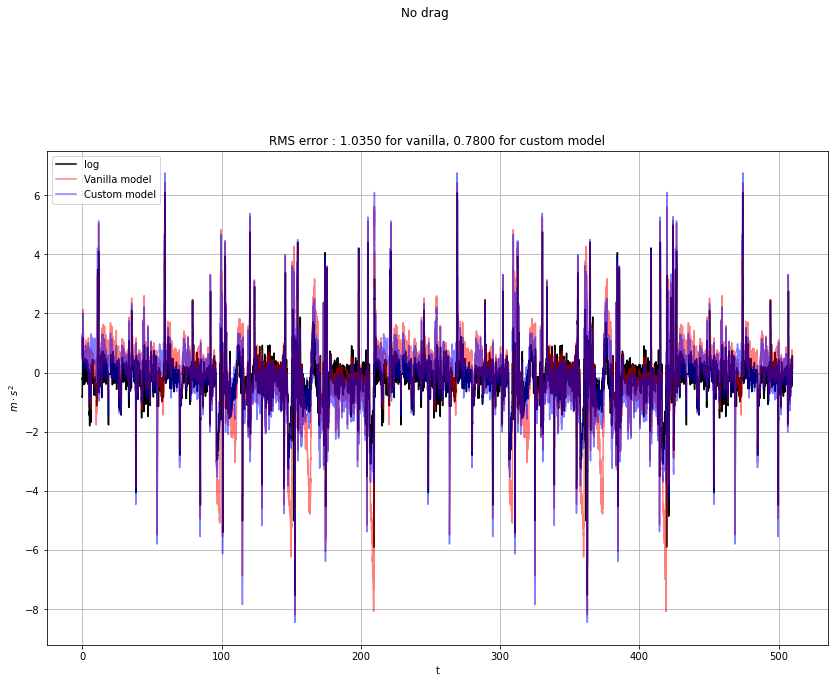

In [5]:
# %%% Comparison

f=plt.figure(figsize=(14,20))
f.suptitle(r"No drag")
ax=f.add_subplot(2,1,1)
ax.plot(prep_data["t"],prep_data['acc_body_grad[2]'],color="black",label=r"log")
ax.plot(prep_data["t"],compute_acc_k(c1vanilla,vanilla=True),color="red",label=r"Vanilla model",alpha=0.5)
ax.plot(prep_data["t"],compute_acc_k(c1sol,c2=c2sol,model="MT"),color="blue",label=r"Custom model",alpha=0.5)
# ax.plot(prep_data["t"],compute_acc_k(c1sol,c2=c2sol,model="BET"),color="green",label=r"optimized, MT",alpha=0.5)
ax.set_ylabel(r'$m \cdot {s^{2}}$')
ax.set_xlabel(r't')
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
s=r"RMS error : %.4f for vanilla, %.4f for custom model"%(round(np.sqrt(sol_vanilla['fun']),3),round(np.sqrt(sol_custom['fun']),4))
print(s)
ax.set_title(s)

print('\n\nCoherence with ct2=ct1*b1-2/b1 formula ?\n')
print('with the formula : ')
print("ct2=%f"%(c1sol*b10-2/b10))
print("with the identification : ")
print("ct2=%f"%(c2sol))


print('\n\nCoherence with TMT=TBET ?\n')
yrms=np.sqrt(np.mean((compute_acc_k(c1sol,c2=c2sol,model="MT")-compute_acc_k(c1sol,c2=c2sol,model="BET"))**2))
print("output difference rms : %s m/s"%(yrms))

In [6]:
compute_acc_k(c1sol,c2=c2sol,model="MT")

1         0.415034
2         0.424218
3         0.430951
4         0.464609
5         0.501423
            ...   
120494   -0.049319
120495   -0.036540
120496   -0.023206
120497   -0.012818
120498   -0.012660
Length: 120498, dtype: float64

In [7]:
c2sol/2/c1sol+0.5*np.sqrt(c2sol**2/c1sol**2+8/c1sol)

13.531036222844767

In [8]:
compute_acc_k(c1sol,c2=c2sol,model="MT")-compute_acc_k(c1sol,c2=c2sol,model="BET")

1         1.776357e-15
2         1.776357e-15
3         1.776357e-15
4         0.000000e+00
5        -1.776357e-15
              ...     
120494    0.000000e+00
120495    3.552714e-15
120496    3.552714e-15
120497    0.000000e+00
120498    0.000000e+00
Length: 120498, dtype: float64

In [36]:

# %%   ####### Identify Thrust(with dk)


def compute_single_motor_thrust_MT_wdrag(c1,vak,omega,c2=0,vanilla_test=False):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)

    T=2*rho0*Area*eta*(eta-vak)

    if vanilla_test:
        T=rho0*Area*r0**2*omega**2*c1
    return T


def compute_single_motor_thrust_BET_wdrag(c1,vak,omega,c2=0,vanilla_test=False):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)

    T=rho0*Area*r0*omega*(c1*r0*omega-c2*(eta-vak))
    if vanilla_test:
        T=rho0*Area*r0**2*omega**2*c1
    return T

def compute_acc_k_wdrag(c1,dk,c2=0,df=prep_data,vanilla=False,model="MT"):
    
    vak=df["speed_body[2]"]
    gamma=df["gamma[2]"]
    
    if model=="MT":
        T_sum=sum([compute_single_motor_thrust_MT(c1,vak,df['omega_c[%i]'%(i+1)],c2,vanilla_test=vanilla) for i in range(6)])
    elif model=="BET":
        T_sum=sum([compute_single_motor_thrust_BET(c1,vak,df['omega_c[%i]'%(i+1)],c2,vanilla_test=vanilla) for i in range(6)])
    else:
        return print("FIX MODEL")
    acc_k=-T_sum/mass+gamma-rho0*AN*dk*np.abs(vak)*vak
    
    return acc_k

from scipy.optimize import minimize

import matplotlib.pyplot as plt


def cost_vanilla_wdrag(X):
    c1,dk=X
    Y=compute_acc_k_wdrag(c1,dk,vanilla=True)
    c=np.mean((Y-prep_data['acc_body_grad[2]'])**2,axis=0)
    print("c1 :%f ,c2: VANILLA , dk: %f ,cost :%f"%(c1,dk,c))
    return c

X0_vanilla=np.array([6e-6,0])

sol_vanilla_drag=minimize(cost_vanilla_wdrag,X0_vanilla,method="SLSQP")
c1vanilla,dkvanilla=sol_vanilla_drag['x']


def cost_wdrag(X):
    c1,c2,dk=X
    Y=compute_acc_k_wdrag(c1,dk,c2=c2)
    c=np.mean((Y-prep_data['acc_body_grad[2]'])**2,axis=0)
    print("c1 :%f ,c2: %f, dk: %f , cost :%f"%(c1,c2,dk,c))
    return c


X0=np.zeros(3)
sol_custom_drag=minimize(cost_wdrag,X0,method="SLSQP")

c1sol,c2sol,dksol=sol_custom_drag['x']



c1 :0.000006 ,c2: VANILLA , dk: 0.000000 ,cost :97.823856
c1 :0.000006 ,c2: VANILLA , dk: 0.000000 ,cost :97.823586
c1 :0.000006 ,c2: VANILLA , dk: 0.000000 ,cost :97.823856
c1 :18106.892889 ,c2: VANILLA , dk: -6.055397 ,cost :277749718352398.218750
c1 :1810.689294 ,c2: VANILLA , dk: -0.605540 ,cost :2777467676235.438965
c1 :181.068935 ,c2: VANILLA , dk: -0.060554 ,cost :27771726120.665932
c1 :18.106899 ,c2: VANILLA , dk: -0.006055 ,cost :277422284.198842
c1 :1.810695 ,c2: VANILLA , dk: -0.000606 ,cost :2744812.302262
c1 :0.181075 ,c2: VANILLA , dk: -0.000061 ,cost :24594.230105
c1 :0.018113 ,c2: VANILLA , dk: -0.000006 ,cost :47.714065
c1 :0.018113 ,c2: VANILLA , dk: -0.000006 ,cost :47.714252
c1 :0.018113 ,c2: VANILLA , dk: -0.000006 ,cost :47.714065
c1 :0.011484 ,c2: VANILLA , dk: 1.818558 ,cost :3.530656
c1 :0.011484 ,c2: VANILLA , dk: 1.818558 ,cost :3.530656
c1 :0.011484 ,c2: VANILLA , dk: 1.818558 ,cost :3.530656
c1 :0.008519 ,c2: VANILLA , dk: -2.033854 ,cost :13.390514
c1 :0.0

/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


c1 :0.019550 ,c2: 0.117479, dk: -0.173306 , cost :0.674879
c1 :0.019550 ,c2: 0.117479, dk: -0.173306 , cost :0.674880
c1 :0.019550 ,c2: 0.117479, dk: -0.173306 , cost :0.674879
c1 :0.019550 ,c2: 0.117479, dk: -0.173306 , cost :0.674879
c1 :0.023024 ,c2: 0.163899, dk: -0.169275 , cost :0.638254
c1 :0.023024 ,c2: 0.163899, dk: -0.169275 , cost :0.638254
c1 :0.023024 ,c2: 0.163899, dk: -0.169275 , cost :0.638254
c1 :0.023024 ,c2: 0.163899, dk: -0.169275 , cost :0.638254
c1 :0.020574 ,c2: 0.129378, dk: -0.036896 , cost :0.617023
c1 :0.020574 ,c2: 0.129378, dk: -0.036896 , cost :0.617024
c1 :0.020574 ,c2: 0.129378, dk: -0.036896 , cost :0.617023
c1 :0.020574 ,c2: 0.129378, dk: -0.036896 , cost :0.617023
c1 :0.011380 ,c2: 0.007626, dk: 0.355000 , cost :0.621274
c1 :0.016233 ,c2: 0.071895, dk: 0.148128 , cost :0.593040
c1 :0.016233 ,c2: 0.071895, dk: 0.148128 , cost :0.593040
c1 :0.016233 ,c2: 0.071895, dk: 0.148128 , cost :0.593040
c1 :0.016233 ,c2: 0.071895, dk: 0.148128 , cost :0.593040
c1

In [10]:

# %%% Comparison

f.suptitle("Thrust no drag / With drag")
ax=f.add_subplot(2,1,2)
ax.plot(prep_data["t"],prep_data['acc_body_grad[2]'],color="black",label="log")
ax.plot(prep_data["t"],compute_acc_k_wdrag(c1vanilla,dkvanilla,vanilla=True),color="red",label="pred",alpha=0.5)
ax.plot(prep_data["t"],compute_acc_k_wdrag(c1sol,dksol,c2=c2sol,model="MT"),color="blue",label="optimized, MT",alpha=0.5)
ax.plot(prep_data["t"],compute_acc_k_wdrag(c1sol,dksol,c2=c2sol,model="BET"),color="green",label="optimized, MT",alpha=0.5)
ax.legend()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
s="%f for vanilla, %f for custom model"%(sol_vanilla_drag['fun'],sol_custom_drag['fun'])
ax.set_title(s)
print(s)


print('\n\nCoherence with ct2=ct1*b1-2/b1 formula ?\n')
print('with the formula : ')
print("ct2=%f"%(c1sol*b10-2/b10))
print("with the identification : ")
print("ct2=%f"%(c2sol))


print('\n\nCoherence with TMT=TBET ?\n')
yrms=np.sqrt(np.mean((compute_acc_k_wdrag(c1sol,dksol,c2=c2sol,model="MT")-compute_acc_k_wdrag(c1sol,dksol,c2=c2sol,model="BET"))**2))
print("output difference rms : %s m/s"%(yrms))

# %%% Comparison
f.suptitle("Vanilla / Augmented with drag")
ax=f.add_subplot(2,1,2)
ax.plot(prep_data["t"],prep_data['acc_body_grad[2]'],color="black",label="log")
ax.plot(prep_data["t"],compute_acc_k_wdrag(c1vanilla,dkvanilla,vanilla=True),color="darkred",label="pred",alpha=0.5)
ax.plot(prep_data["t"],compute_acc_k_wdrag(c1sol,dksol,c2=c2sol,model="MT"),color="darkblue",label="optimized, MT",alpha=0.5)
ax.plot(prep_data["t"],compute_acc_k_wdrag(c1sol,dksol,c2=c2sol,model="BET"),color="darkgreen",label="optimized, MT",alpha=0.5)
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
print("%f for vanilla, %f for custom model"%(sol_vanilla_drag['fun'],sol_custom_drag['fun']))


print('\n\nCoherence with ct2=ct1*b1-2/b1 formula ?\n')
print('with the formula : ')
print("ct2=%f"%(c1sol*b10-2/b10))
print("with the identification : ")
print("ct2=%f"%(c2sol))


print('\n\nCoherence with TMT=TBET ?\n')
yrms=np.sqrt(np.mean((compute_acc_k_wdrag(c1sol,dkvanilla,c2=c2sol,model="MT")-compute_acc_k_wdrag(c1sol,dkvanilla,c2=c2sol,model="BET"))**2))
print("output difference rms : %s m/s"%(yrms))


Performances: 
RMS error on acc pred is : 
0.597303 for vanilla, 0.586809 for custom model


Coherence with ct2=ct1*b1-2/b1 formula ?

with the formula : 
ct2=0.060659
with the identification : 
ct2=0.038738


Coherence with TMT=TBET ?

output difference rms : 1.6214371537827286e-15 m/s

Performances: 
RMS error on acc pred is : 
0.597303 for vanilla, 0.586809 for custom model


Coherence with ct2=ct1*b1-2/b1 formula ?

with the formula : 
ct2=0.060659
with the identification : 
ct2=0.038738


Coherence with TMT=TBET ?

output difference rms : 1.6214290786149996e-15 m/s


In [11]:

# %%%   ####### Identify pure drag

def compute_ai_od(di,df=prep_data):
    
    vak=df["speed_body[0]"]
    Fa=-rho0*AN*di*np.abs(vak)*vak
    gamma=df["gamma[0]"]

    return Fa+gamma

def cost_ai_onlydrag(X):
    di=X
    
    Y=compute_ai_od(di)
    c=np.mean((Y-prep_data['acc_body_grad[0]'])**2,axis=0)
    print("di :%f , cost :%f"%(di,c))

    return c
    
X0_di_onlydrag=np.array([0])

sol_ai_od=minimize(cost_ai_onlydrag,X0_di_onlydrag,method="SLSQP")
di_only_=sol_ai_od['x']
print("\n \n")


di :0.000000 , cost :0.084489
di :0.000000 , cost :0.084489
di :0.169518 , cost :0.060381
di :0.169518 , cost :0.060381
di :0.526284 , cost :0.039882
di :0.526284 , cost :0.039882

 



In [12]:

# %%%   ####### Identify H-force nodrag


def compute_eta(vak,omega,c1=c1sol,c2=c2sol):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)
    return eta

def compute_H(vak,omega,ch1,ch2):
    eta=compute_eta(vak,omega)
    H=rho0*Area*(ch1*r0*omega-ch2*(eta-vak))
    return H

def compute_ai_H_only(ch1,ch2,df=prep_data):

    vai=df["speed_body[0]"]
    vak=df["speed_body[2]"]

    gamma=df["gamma[0]"]
    
    H=sum([compute_H(vak,df['omega_c[%i]'%(i+1)],ch1,ch2) for i in range(6)])
    H_vect=-vai*H
    
    return H_vect+gamma

def cost_ai_h_only(X):
    ch1,ch2=X

    Y=compute_ai_H_only(ch1,ch2)
    c=np.mean((Y-prep_data['acc_body_grad[0]'])**2,axis=0)
    print("ch1 :%f , ch2 :%f , cost :%f"%(ch1,ch2,c))

    return c

X0_ai_onlyh=np.array([0,0])

sol_ai_oh=minimize(cost_ai_h_only,X0_ai_onlyh,method="SLSQP")
ch1_ai_only_,ch2_ai_only_=sol_ai_oh['x']
print("\n \n")

ch1 :0.000000 , ch2 :0.000000 , cost :0.084489
ch1 :0.000000 , ch2 :0.000000 , cost :0.084489
ch1 :0.000000 , ch2 :0.000000 , cost :0.084489
ch1 :8.152170 , ch2 :-0.648122 , cost :23106.568821
ch1 :0.815217 , ch2 :-0.064812 , cost :225.130315
ch1 :0.081522 , ch2 :-0.006481 , cost :1.733046
ch1 :0.011764 , ch2 :-0.000935 , cost :0.036237
ch1 :0.011764 , ch2 :-0.000935 , cost :0.036237
ch1 :0.011764 , ch2 :-0.000935 , cost :0.036237
ch1 :0.011292 , ch2 :-0.006920 , cost :0.036202
ch1 :0.011292 , ch2 :-0.006920 , cost :0.036202
ch1 :0.011292 , ch2 :-0.006920 , cost :0.036202
ch1 :0.009125 , ch2 :-0.034436 , cost :0.036081
ch1 :0.009125 , ch2 :-0.034436 , cost :0.036081
ch1 :0.009125 , ch2 :-0.034436 , cost :0.036081
ch1 :0.005908 , ch2 :-0.075272 , cost :0.036013
ch1 :0.005908 , ch2 :-0.075272 , cost :0.036013
ch1 :0.005908 , ch2 :-0.075272 , cost :0.036013

 



In [13]:

# %%%   ####### Identify H-force wdrag


def compute_eta(vak,omega,c1=c1sol,c2=c2sol):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)
    return eta

def compute_H(vak,omega,ch1,ch2):
    eta=compute_eta(vak,omega)
    H=rho0*Area*(ch1*r0*omega-ch2*(eta-vak))
    return H

def compute_ai_H_wdrag(ch1,ch2,di,df=prep_data):
    
    vai=df["speed_body[0]"]
    vak=df["speed_body[2]"]

    gamma=df["gamma[0]"]
    
    H=sum([compute_H(vak,df['omega_c[%i]'%(i+1)],ch1,ch2) for i in range(6)])
    H_vect=-vai*H
    Fa=-rho0*Area*di*np.abs(vai)*vai

    return H_vect+gamma+Fa

def cost_ai_h_wdrag(X):
    ch1,ch2,di=X

    Y=compute_ai_H_wdrag(ch1,ch2,di)
    c=np.mean((Y-prep_data['acc_body_grad[0]'])**2,axis=0)
    print("ch1 :%f , ch2 :%f , di :%f , cost :%f"%(ch1,ch2,di,c))

    return c

X0_ai_hwd=np.array([0,0,0])

sol_ai_hwd=minimize(cost_ai_h_wdrag,X0_ai_hwd,method="SLSQP")
ch1_ai_wd_,ch2_ai_wd_,di_wd_=sol_ai_hwd['x']

ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , cost :0.084489
ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , cost :0.084489
ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , cost :0.084489
ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , cost :0.084489
ch1 :8.152170 , ch2 :-0.648122 , di :0.028253 , cost :23107.093420
ch1 :0.815217 , ch2 :-0.064812 , di :0.002825 , cost :225.135489
ch1 :0.081522 , ch2 :-0.006481 , di :0.000283 , cost :1.733090
ch1 :0.011763 , ch2 :-0.000935 , di :0.000041 , cost :0.036237
ch1 :0.011763 , ch2 :-0.000935 , di :0.000041 , cost :0.036237
ch1 :0.011763 , ch2 :-0.000935 , di :0.000041 , cost :0.036237
ch1 :0.011763 , ch2 :-0.000935 , di :0.000041 , cost :0.036237
ch1 :0.011287 , ch2 :-0.006920 , di :0.001460 , cost :0.036200
ch1 :0.011287 , ch2 :-0.006920 , di :0.001460 , cost :0.036200
ch1 :0.011287 , ch2 :-0.006920 , di :0.001460 , cost :0.036200
ch1 :0.011287 , ch2 :-0.006920 , di :0.001460 , cost :0.036200
ch1 :0.009094 , ch2 :-0.034467 , di :0.008534 , cost 


Performances: 
RMS error on acc pred is : 
0.039882 for vanilla, 0.036013 for custom model, 0.035378 for full model
dj :1.000000 , cost :0.391147
dj :1.000000 , cost :0.391147
dj :-0.070836 , cost :0.817377
dj :0.609669 , cost :0.182157
dj :0.609669 , cost :0.182157

 



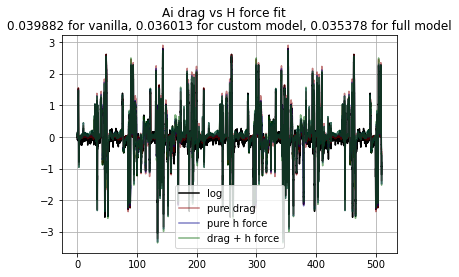

In [14]:

# %%%   ####### Comparison

f=plt.figure()
f.suptitle("Ai drag vs H force fit")
ax=f.add_subplot(1,1,1)
ax.plot(prep_data["t"],prep_data['acc_body_grad[0]'],color="black",label="log")
ax.plot(prep_data["t"],compute_ai_od(di_only_),color="darkred",label="pure drag",alpha=0.5)
ax.plot(prep_data["t"],compute_ai_H_only(ch1_ai_only_,ch2_ai_only_),color="darkblue",label="pure h force",alpha=0.5)
ax.plot(prep_data["t"],compute_ai_H_wdrag(ch1_ai_only_,ch2_ai_only_,di_wd_),color="darkgreen",label="drag + h force",alpha=0.5)
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
s="%f for vanilla, %f for custom model, %f for full model"%(sol_ai_od['fun'],sol_ai_oh['fun'],sol_ai_hwd['fun'])
ax.set_title(s)
print(s)

# %% aj
# %%%   ####### Identify pure drag

def compute_aj_od(dj,df=prep_data):
    
    vak=df["speed_body[1]"]
    Fa=-rho0*Area*dj*np.abs(vak)*vak
    gamma=df["gamma[1]"]

    return Fa+gamma

def cost_aj_onlydrag(X):
    dj=X
    
    Y=compute_aj_od(dj)
    c=np.mean((Y-prep_data['acc_body_grad[1]'])**2,axis=0)
    print("dj :%f , cost :%f"%(dj,c))

    return c
    
X0_dj_onlydrag=np.array([1])

sol_aj_od=minimize(cost_aj_onlydrag,X0_dj_onlydrag,method="SLSQP")
dj_only_=sol_aj_od['x']
print("\n \n")

In [15]:


# %%%   ####### Identify H-force nodrag


def compute_eta(vak,omega,c1=c1sol,c2=c2sol):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)
    return eta

def compute_H(vak,omega,ch1,ch2):
    eta=compute_eta(vak,omega)
    H=rho0*Area*(ch1*r0*omega-ch2*(eta-vak))
    return H

def compute_aj_H_only(ch1,ch2,df=prep_data):
    
    vak=df["speed_body[2]"]
    vaj=df["speed_body[1]"]

    gamma=df["gamma[1]"]
    
    H=sum([compute_H(vak,df['omega_c[%i]'%(i+1)],ch1,ch2) for i in range(6)])
    H_vect=-vaj*H
    
    return H_vect+gamma

def cost_aj_h_only(X):
    ch1,ch2=X

    Y=compute_aj_H_only(ch1,ch2)
    c=np.mean((Y-prep_data['acc_body_grad[1]'])**2,axis=0)
    print("ch1 :%f , ch2 :%f , cost :%f"%(ch1,ch2,c))

    return c

X0_aj_onlyh=np.array([0,0])

sol_aj_oh=minimize(cost_aj_h_only,X0_aj_onlyh,method="SLSQP")
ch1_aj_only_,ch2_aj_only_=sol_aj_oh['x']
print("\n \n")


ch1 :0.000000 , ch2 :0.000000 , cost :0.692015
ch1 :0.000000 , ch2 :0.000000 , cost :0.692013
ch1 :0.000000 , ch2 :0.000000 , cost :0.692015
ch1 :104.634375 , ch2 :-9.137107 , cost :53303029.781293
ch1 :10.463437 , ch2 :-0.913711 , cost :532038.116709
ch1 :1.046344 , ch2 :-0.091371 , cost :5221.779642
ch1 :0.104634 , ch2 :-0.009137 , cost :42.974229
ch1 :0.010826 , ch2 :-0.000945 , cost :0.121332
ch1 :0.010826 , ch2 :-0.000945 , cost :0.121332
ch1 :0.010826 , ch2 :-0.000945 , cost :0.121332
ch1 :-0.007033 , ch2 :-0.210284 , cost :0.120405
ch1 :0.001705 , ch2 :-0.107859 , cost :0.110060
ch1 :0.001705 , ch2 :-0.107859 , cost :0.110060
ch1 :0.001705 , ch2 :-0.107859 , cost :0.110060

 



In [16]:

# %%%   ####### Identify H-force wdrag


def compute_eta(vak,omega,c1=c1sol,c2=c2sol):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)
    return eta

def compute_H(vak,omega,ch1,ch2):
    eta=compute_eta(vak,omega)
    H=rho0*Area*(ch1*r0*omega-ch2*(eta-vak))
    return H

def compute_aj_H_wdrag(ch1,ch2,dj,df=prep_data):
    
    vak=df["speed_body[2]"]
    vaj=df["speed_body[1]"]

    gamma=df["gamma[1]"]
    
    H=sum([compute_H(vak,df['omega_c[%i]'%(i+1)],ch1,ch2) for i in range(6)])
    H_vect=-vaj*H
    Fa=-rho0*Area*dj*np.abs(vaj)*vaj

    return H_vect+gamma+Fa

def cost_aj_h_wdrag(X):
    ch1,ch2,dj=X

    Y=compute_aj_H_wdrag(ch1,ch2,dj)
    c=np.mean((Y-prep_data['acc_body_grad[1]'])**2,axis=0)
    print("ch1 :%f , ch2 :%f , dj :%f , cost :%f"%(ch1,ch2,dj,c))

    return c

X0_aj_hwd=np.array([0,0,0])

sol_aj_hwd=minimize(cost_aj_h_wdrag,X0_aj_hwd,method="SLSQP")
ch1_aj_wd_,ch2_aj_wd_,dj_wd_=sol_aj_hwd['x']

ch1 :0.000000 , ch2 :0.000000 , dj :0.000000 , cost :0.692015
ch1 :0.000000 , ch2 :0.000000 , dj :0.000000 , cost :0.692013
ch1 :0.000000 , ch2 :0.000000 , dj :0.000000 , cost :0.692015
ch1 :0.000000 , ch2 :0.000000 , dj :0.000000 , cost :0.692015
ch1 :104.634375 , ch2 :-9.137107 , dj :1.672571 , cost :53329406.542084
ch1 :10.463437 , ch2 :-0.913711 , dj :0.167257 , cost :532301.632542
ch1 :1.046344 , ch2 :-0.091371 , dj :0.016726 , cost :5224.389623
ch1 :0.104634 , ch2 :-0.009137 , dj :0.001673 , cost :42.997811
ch1 :0.010823 , ch2 :-0.000945 , dj :0.000173 , cost :0.121325
ch1 :0.010823 , ch2 :-0.000945 , dj :0.000173 , cost :0.121325
ch1 :0.010823 , ch2 :-0.000945 , dj :0.000173 , cost :0.121325
ch1 :0.010823 , ch2 :-0.000945 , dj :0.000173 , cost :0.121325
ch1 :-0.007668 , ch2 :-0.210211 , dj :0.041136 , cost :0.120006
ch1 :0.001303 , ch2 :-0.108681 , dj :0.021262 , cost :0.109533
ch1 :0.001303 , ch2 :-0.108681 , dj :0.021262 , cost :0.109533
ch1 :0.001303 , ch2 :-0.108681 , dj :0.


Performances: 
RMS error on acc pred is : 
0.182157 for vanilla 
 0.110060 for custom model 
 0.108999 for full model


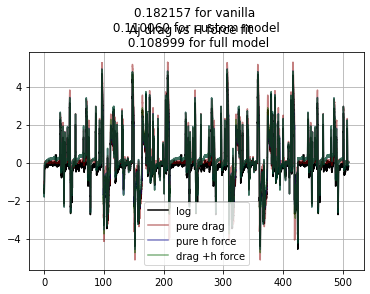

In [17]:
# %%%   ####### Comparison

f=plt.figure()
f.suptitle("Aj drag vs H force fit")
ax=f.add_subplot(1,1,1)
ax.plot(prep_data["t"],prep_data['acc_body_grad[1]'],color="black",label="log")
ax.plot(prep_data["t"],compute_aj_od(dj_only_),color="darkred",label="pure drag",alpha=0.5)
ax.plot(prep_data["t"],compute_aj_H_only(ch1_aj_only_,ch2_aj_only_),color="darkblue",label="pure h force",alpha=0.5)
ax.plot(prep_data["t"],compute_aj_H_wdrag(ch1_aj_only_,ch2_aj_only_,dj_wd_),color="darkgreen",label="drag +h force",alpha=0.5)
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
s="%f for vanilla \n %f for custom model \n %f for full model"%(sol_aj_od['fun'],sol_aj_oh['fun'],sol_aj_hwd["fun"])
ax.set_title(s)
print(s)
# %% aij

In [18]:


# %%% H nodrag

def compute_aij_H_wdrag(ch1,ch2,di=0,dj=0,df=prep_data):
    
    vai=df["speed_body[0]"]
    vaj=df["speed_body[1]"]
    vak=df["speed_body[2]"]
    gammai=df["gamma[0]"]
    gammaj=df["gamma[1]"]

    H=sum([compute_H(vak,df['omega_c[%i]'%(i+1)],ch1,ch2) for i in range(6)])
    H_vect=np.c_[-vai*H,-vaj*H]
    
    Fa=-rho0*Area*np.c_[di*np.abs(vai)*vai,dj*np.abs(vaj)*vaj]

    return H_vect+np.c_[gammai,gammaj]+Fa

def cost_aij_h_nodrag(X):
    ch1,ch2=X
    Y=compute_aij_H_wdrag(ch1,ch2,di=0,dj=0)
    ci=np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2,axis=0)
    cj=np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2,axis=0)

    c=ci+cj
    print("ch1 :%f , ch2 :%f , cost :%f"%(ch1,ch2,c))

    return c

X0_aij_nodrag=np.array([0,0])

sol_aij_nodrag=minimize(cost_aij_h_nodrag,X0_aij_nodrag,method="SLSQP")
ch1_aij_nodrag_,ch2_aij_nodrag_=sol_aij_nodrag['x']



ch1 :0.000000 , ch2 :0.000000 , cost :0.776504
ch1 :0.000000 , ch2 :0.000000 , cost :0.776502
ch1 :0.000000 , ch2 :0.000000 , cost :0.776504
ch1 :112.786544 , ch2 :-9.785228 , cost :66367131.566602
ch1 :11.278654 , ch2 :-0.978523 , cost :662518.593645
ch1 :1.127865 , ch2 :-0.097852 , cost :6510.605599
ch1 :0.112787 , ch2 :-0.009785 , cost :54.339887
ch1 :0.011279 , ch2 :-0.000979 , cost :0.158647
ch1 :0.011279 , ch2 :-0.000979 , cost :0.158647
ch1 :0.011279 , ch2 :-0.000979 , cost :0.158647
ch1 :-0.007055 , ch2 :-0.212365 , cost :0.159334
ch1 :0.002245 , ch2 :-0.105136 , cost :0.147164
ch1 :0.002245 , ch2 :-0.105136 , cost :0.147164
ch1 :0.002245 , ch2 :-0.105136 , cost :0.147164
ch1 :0.002202 , ch2 :-0.103255 , cost :0.146956
ch1 :0.002202 , ch2 :-0.103255 , cost :0.146956
ch1 :0.002202 , ch2 :-0.103255 , cost :0.146956


In [19]:


# %%% H wd


def cost_aij_h_wdrag(X):
    ch1,ch2,di,dj=X

    Y=compute_aij_H_wdrag(ch1,ch2,di,dj)

    ci=np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2,axis=0)
    cj=np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2,axis=0)

    c=ci+cj

    print("ch1 :%f , ch2 :%f , di :%f , dj : %f , cost :%f"%(ch1,ch2,di,dj,c))

    return c

X0_aij_hwd=np.array([0,0,0,0])

sol_aij_hwd=minimize(cost_aij_h_wdrag,X0_aij_hwd,method="SLSQP")
ch1_aij_wd_,ch2_aij_wd_,di_aij_wd_,dj_aij_wd_=sol_aij_hwd['x']

ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , cost :0.776504
ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , cost :0.776502
ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , cost :0.776504
ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , cost :0.776504
ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , cost :0.776504
ch1 :112.786544 , ch2 :-9.785228 , di :0.028253 , dj : 1.672571 , cost :66395569.186098
ch1 :11.278654 , ch2 :-0.978523 , di :0.002825 , dj : 0.167257 , cost :662802.717993
ch1 :1.127865 , ch2 :-0.097852 , di :0.000283 , dj : 0.016726 , cost :6513.421658
ch1 :0.112787 , ch2 :-0.009785 , di :0.000028 , dj : 0.001673 , cost :54.365529
ch1 :0.011279 , ch2 :-0.000979 , di :0.000003 , dj : 0.000167 , cost :0.158651
ch1 :0.011279 , ch2 :-0.000979 , di :0.000003 , dj : 0.000167 , cost :0.158651
ch1 :0.011279 , ch2 :-0.000979 , di :0.000003 , dj : 0.000167 , cost :0.158651
ch1 :0.011279 , ch2 :-0.000979 , di :0


Performances: 
RMS error on acc pred is : 
0.039882 for vanilla 
  0.036823 for custom model 
 0.035430 for full model

Performances: 
RMS error on acc pred is : 
0.182157 for vanilla 
 1.582875 for custom model 
 1.594520 for full model


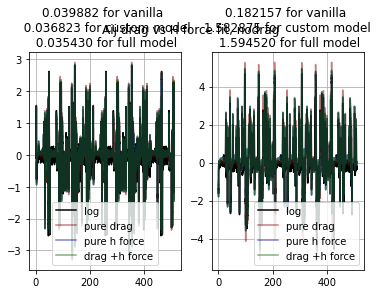

In [20]:



# %%% Comparison ai
aind,ajnd=compute_aij_H_wdrag(ch1_aij_nodrag_,ch2_aij_nodrag_).T
aid,ajd=compute_aij_H_wdrag(ch1_aij_wd_,ch2_aij_wd_,di_aij_wd_,dj_aij_wd_).T

f=plt.figure()
f.suptitle("Aij drag vs H force fit, nodrag")
ax=f.add_subplot(1,2,1)
ax.plot(prep_data["t"],prep_data['acc_body_grad[0]'],color="black",label="log")
ax.plot(prep_data["t"],compute_ai_od(di_only_),color="darkred",label="pure drag",alpha=0.5)
ax.plot(prep_data["t"],aind,color="darkblue",label="pure h force",alpha=0.5)
ax.plot(prep_data["t"],aid,color="darkgreen",label="drag +h force",alpha=0.5)
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
c_i_nd=np.mean((aind-prep_data['acc_body_grad[0]'])**2,axis=0)
c_i_d=np.mean((aid-prep_data['acc_body_grad[0]'])**2,axis=0)                            
s="%f for vanilla \n  %f for custom model \n %f for full model"%(sol_ai_od['fun'],c_i_nd,c_i_d)
ax.set_title(s)
print(s)

# %%% Comparison aj

ax=f.add_subplot(1,2,2)
ax.plot(prep_data["t"],prep_data['acc_body_grad[1]'],color="black",label="log")
ax.plot(prep_data["t"],compute_aj_od(dj_only_),color="darkred",label="pure drag",alpha=0.5)
ax.plot(prep_data["t"],ajnd,color="darkblue",label="pure h force",alpha=0.5)
ax.plot(prep_data["t"],ajd,color="darkgreen",label="drag +h force",alpha=0.5)
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
c_j_nd=np.mean((ajnd-prep_data['acc_body_grad[0]'])**2,axis=0)
c_j_d=np.mean((ajd-prep_data['acc_body_grad[0]'])**2,axis=0)  
s="%f for vanilla \n %f for custom model \n %f for full model"%(sol_aj_od['fun'],c_j_nd,c_j_d)
ax.set_title(s)
print(s)



In [21]:


# %% aij (di_eq_dj)
 
# %%% H nodrag

def compute_aij_H_wdrag(ch1,ch2,di=0,dj=0,df=prep_data):
    
    vai=df["speed_body[0]"]
    vaj=df["speed_body[1]"]
    vak=df["speed_body[2]"]
    gammai=df["gamma[0]"]
    gammaj=df["gamma[1]"]

    H=sum([compute_H(vak,df['omega_c[%i]'%(i+1)],ch1,ch2) for i in range(6)])
    H_vect=np.c_[-vai*H,-vaj*H]
    
    Fa=-rho0*Area*np.c_[di*np.abs(vai)*vai,dj*np.abs(vaj)*vaj]

    return H_vect+np.c_[gammai,gammaj]+Fa


# %%% H wd


def cost_aij_h_wdrag_di_eq_dj_(X):
    ch1,ch2,di=X

    Y=compute_aij_H_wdrag(ch1,ch2,di,di)

    ci=np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2,axis=0)
    cj=np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2,axis=0)

    c=ci+cj

    print("ch1 :%f , ch2 :%f , dij :%f  , cost :%f"%(ch1,ch2,di,c))

    return c

X0_aij_hwd_di_eq_dj_=np.array([0,0,0])

sol_aij_hwd_di_eq_dj_=minimize(cost_aij_h_wdrag_di_eq_dj_,X0_aij_hwd_di_eq_dj_,method="SLSQP")
ch1_aij_wd_di_eq_dj_,ch2_aij_wd_di_eq_dj_,dij_aij_wd_di_eq_dj_=sol_aij_hwd_di_eq_dj_['x']


ch1 :0.000000 , ch2 :0.000000 , dij :0.000000  , cost :0.776504
ch1 :0.000000 , ch2 :0.000000 , dij :0.000000  , cost :0.776502
ch1 :0.000000 , ch2 :0.000000 , dij :0.000000  , cost :0.776504
ch1 :0.000000 , ch2 :0.000000 , dij :0.000000  , cost :0.776504
ch1 :112.786544 , ch2 :-9.785228 , dij :1.700824  , cost :66396480.024591
ch1 :11.278654 , ch2 :-0.978523 , dij :0.170082  , cost :662811.817872
ch1 :1.127865 , ch2 :-0.097852 , dij :0.017008  , cost :6513.511806
ch1 :0.112787 , ch2 :-0.009785 , dij :0.001701  , cost :54.366346
ch1 :0.011279 , ch2 :-0.000979 , dij :0.000170  , cost :0.158651
ch1 :0.011279 , ch2 :-0.000979 , dij :0.000170  , cost :0.158651
ch1 :0.011279 , ch2 :-0.000979 , dij :0.000170  , cost :0.158651
ch1 :0.011279 , ch2 :-0.000979 , dij :0.000170  , cost :0.158651
ch1 :-0.007568 , ch2 :-0.212295 , dij :0.035135  , cost :0.159614
ch1 :0.002041 , ch2 :-0.104551 , dij :0.017308  , cost :0.146927
ch1 :0.002041 , ch2 :-0.104551 , dij :0.017308  , cost :0.146927
ch1 :0.00


Performances: 
RMS error on acc pred is : 
0.146612 for vanilla 
 0.037460 for custom model 
 0.037245 for full model

Performances: 
RMS error on acc pred is : 
0.146612 for vanilla 
 1.585193 for custom model 
 1.591160 for full model


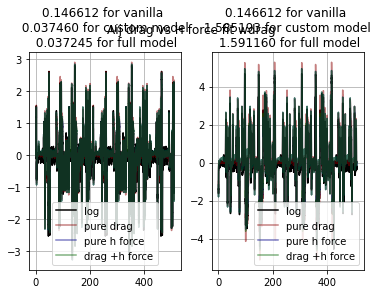

In [22]:


# %%% Comparison ai
aind,ajnd=compute_aij_H_wdrag(ch1_aij_wd_di_eq_dj_,ch2_aij_wd_di_eq_dj_).T
aid,ajd=compute_aij_H_wdrag(ch1_aij_wd_di_eq_dj_,ch2_aij_wd_di_eq_dj_,dij_aij_wd_di_eq_dj_,dij_aij_wd_di_eq_dj_).T

f=plt.figure()
f.suptitle("Aij drag vs H force fit wdrag")
ax=f.add_subplot(1,2,1)
ax.plot(prep_data["t"],prep_data['acc_body_grad[0]'],color="black",label="log")
ax.plot(prep_data["t"],compute_ai_od(di_only_),color="darkred",label="pure drag",alpha=0.5)
ax.plot(prep_data["t"],aind,color="darkblue",label="pure h force",alpha=0.5)
ax.plot(prep_data["t"],aid,color="darkgreen",label="drag +h force",alpha=0.5)
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
c_i_nd=np.mean((aind-prep_data['acc_body_grad[0]'])**2,axis=0)
c_i_d=np.mean((aid-prep_data['acc_body_grad[0]'])**2,axis=0)                            
s="%f for vanilla \n %f for custom model \n %f for full model"%(sol_aij_hwd_di_eq_dj_['fun'],c_i_nd,c_i_d)
ax.set_title(s)
print(s)

# %%% Comparison aj

ax=f.add_subplot(1,2,2)
ax.plot(prep_data["t"],prep_data['acc_body_grad[1]'],color="black",label="log")
ax.plot(prep_data["t"],compute_aj_od(dj_only_),color="darkred",label="pure drag",alpha=0.5)
ax.plot(prep_data["t"],ajnd,color="darkblue",label="pure h force",alpha=0.5)
ax.plot(prep_data["t"],ajd,color="darkgreen",label="drag +h force",alpha=0.5)
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
c_j_nd=np.mean((ajnd-prep_data['acc_body_grad[0]'])**2,axis=0)
c_j_d=np.mean((ajd-prep_data['acc_body_grad[0]'])**2,axis=0)  
s="%f for vanilla \n %f for custom model \n %f for full model"%(sol_aij_hwd_di_eq_dj_['fun'],c_j_nd,c_j_d)
ax.set_title(s)
print(s)

In [23]:


# %% Global 

def compute_eta(vak,omega,c1=c1sol,c2=c2sol):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)
    return eta

def compute_H(vak,omega,ch1,ch2):
    eta=compute_eta(vak,omega)
    H=rho0*Area*(ch1*r0*omega-ch2*(eta-vak))
    return H


def compute_single_motor_thrust_MT(c1,vak,omega,c2=0,vanilla_test=False):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)

    T=2*rho0*Area*eta*(eta-vak)

    if vanilla_test:
        T=c1*omega**2
    return T

def compute_acc_k(c1,c2=0,df=prep_data,vanilla=False,model="MT"):
    
    vak=df["speed_body[2]"]
    gamma=df["gamma[2]"]
    
    if model=="MT":
        T_sum=sum([compute_single_motor_thrust_MT(c1,vak,df['omega_c[%i]'%(i+1)],c2,vanilla_test=vanilla) for i in range(6)])
    elif model=="BET":
        T_sum=sum([compute_single_motor_thrust_BET(c1,vak,df['omega_c[%i]'%(i+1)],c2,vanilla_test=vanilla) for i in range(6)])
    else:
        return print("FIX MODEL")
    acc_k=-T_sum/mass+gamma
    
    return acc_k


def compute_acc_global(ct1,ct2,ch1,ch2,di=0,dj=0,dk=0,df=prep_data):
    
    vai=df["speed_body[0]"]
    vaj=df["speed_body[1]"]
    vak=df["speed_body[2]"]
    
    gammai=df["gamma[0]"]
    gammaj=df["gamma[1]"]
    gammak=df["gamma[2]"]
    
    T=sum([compute_single_motor_thrust_MT(ct1,vak,df['omega_c[%i]'%(i+1)],ct2) for i in range(6)])
    H=sum([compute_H(vak,df['omega_c[%i]'%(i+1)],ch1,ch2) for i in range(6)])
    
    H_vect=np.c_[-vai*H,-vaj*H,np.zeros(H.shape)]
    T_vect=np.c_[np.zeros(T.shape),np.zeros(T.shape),T]
    absva=np.sqrt(vai**2+vaj**2+vak**2)
    Fa=-rho0*Area*np.c_[di*absva*vai,dj*absva*vaj,dk*absva*vak]

    return -T_vect/mass+H_vect+np.c_[gammai,gammaj,gammak]+Fa


def cost_global_(X):
    ct1,ct2,ch1,ch2,di,dj,dk=X

    Y=compute_acc_global(ct1,ct2,ch1,ch2,di,dj,dk)

    ci=np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2/max(abs(prep_data['acc_body_grad[0]']))**2,axis=0)
    cj=np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2/max(abs(prep_data['acc_body_grad[1]']))**2,axis=0)
    ck=np.mean((Y[:,2]-prep_data['acc_body_grad[2]'])**2/max(abs(prep_data['acc_body_grad[2]']))**2,axis=0)
    
    c=ci+cj+ck

    print("ct1 :%f, ct2 :%f , ch1 :%f , ch2 :%f , di :%f , dj : %f , dk : %f , cost :%f"%(ct1,ct2,ch1,ch2,di,dj,dk,c))

    return c

X0_global_=np.zeros(7)

sol_global_=minimize(cost_global_,X0_global_,method="SLSQP")
ct1_global,ct2_global,ch1_global,ch2_global,di_global,dj_global,dk_global=sol_global_['x']


ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.768746
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.768741
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.768746
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.768746
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.768746
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.768746
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.768746
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.768746



Performances: 
RMS error on acc pred is : 
0.036559 for i 
 0.110039 for j 
 0.581327 for k


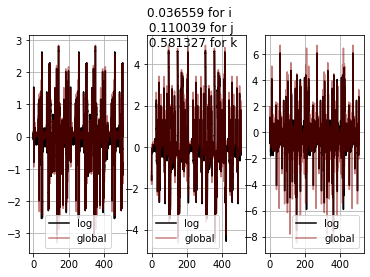

In [24]:




# %%% Comparison a i j k
Y=compute_acc_global(ct1_global,ct2_global,ch1_global,ch2_global,di_global,dj_global,dk_global)

f=plt.figure()
ax=f.add_subplot(1,3,1)
ax.plot(prep_data["t"],prep_data['acc_body_grad[0]'],color="black",label="log")
ax.plot(prep_data["t"],Y[:,0],color="darkred",label="global",alpha=0.5)
ax.legend(),ax.grid()

ax=f.add_subplot(1,3,2)
ax.plot(prep_data["t"],prep_data['acc_body_grad[1]'],color="black",label="log")
ax.plot(prep_data["t"],Y[:,1],color="darkred",label="global",alpha=0.5)
ax.legend(),ax.grid()

ax=f.add_subplot(1,3,3)
ax.plot(prep_data["t"],prep_data['acc_body_grad[2]'],color="black",label="log")
ax.plot(prep_data["t"],Y[:,2],color="darkred",label="global",alpha=0.5)
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
c_i_=np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2,axis=0)
c_j_=np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2,axis=0)  
c_k_=np.mean((Y[:,2]-prep_data['acc_body_grad[2]'])**2,axis=0)  


s="%f for i \n %f for j \n %f for k"%(c_i_,c_j_,c_k_)
f.suptitle(s)
print(s)



In [25]:


# %% Global 

def compute_eta(vak,omega,c1=c1sol,c2=c2sol):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)
    return eta

def compute_H(vak,omega,ch1,ch2):
    eta=compute_eta(vak,omega)
    H=rho0*Area*(ch1*r0*omega-ch2*(eta-vak))
    return H


def compute_single_motor_thrust_MT(c1,vak,omega,c2=0,vanilla_test=False):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)

    T=2*rho0*Area*eta*(eta-vak)

    if vanilla_test:
        T=c1*omega**2
    return T

def compute_acc_k(c1,c2=0,df=prep_data,vanilla=False,model="MT"):
    
    vak=df["speed_body[2]"]
    gamma=df["gamma[2]"]
    
    if model=="MT":
        T_sum=sum([compute_single_motor_thrust_MT(c1,vak,df['omega_c[%i]'%(i+1)],c2,vanilla_test=vanilla) for i in range(6)])
    elif model=="BET":
        T_sum=sum([compute_single_motor_thrust_BET(c1,vak,df['omega_c[%i]'%(i+1)],c2,vanilla_test=vanilla) for i in range(6)])
    else:
        return print("FIX MODEL")
    acc_k=-T_sum/mass+gamma
    
    return acc_k


def compute_acc_global(ct1,ct2,ch1,ch2,di=0,dj=0,dk=0,df=prep_data,vwi=0,vwj=0):
    
    vai=df["speed_body[0]"]
    vaj=df["speed_body[1]"]
    vak=df["speed_body[2]"]
    
    gammai=df["gamma[0]"]
    gammaj=df["gamma[1]"]
    gammak=df["gamma[2]"]
    
    T=sum([compute_single_motor_thrust_MT(ct1,vak,df['omega_c[%i]'%(i+1)],ct2) for i in range(6)])
    H=sum([compute_H(vak,df['omega_c[%i]'%(i+1)],ch1,ch2) for i in range(6)])
    
    H_vect=np.c_[-vai*H,-vaj*H,np.zeros(H.shape)]
    T_vect=np.c_[np.zeros(T.shape),np.zeros(T.shape),T]
    absva=np.sqrt(vai**2+vaj**2+vak**2)
    Fa=-rho0*Area*np.c_[di*absva*vai,dj*absva*vaj,dk*absva*vak]

    return -T_vect/mass+H_vect+np.c_[gammai,gammaj,gammak]+Fa


def cost_global_dij_(X):
    ct1,ct2,ch1,ch2,dij,dk=X

    Y=compute_acc_global(ct1,ct2,ch1,ch2,dij,dij,dk)

    ci=np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2/max(abs(prep_data['acc_body_grad[0]']))**2,axis=0)
    cj=np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2/max(abs(prep_data['acc_body_grad[1]']))**2,axis=0)
    ck=np.mean((Y[:,2]-prep_data['acc_body_grad[2]'])**2/max(abs(prep_data['acc_body_grad[2]']))**2,axis=0)
    
    c=ci+cj+ck

    print("ct1 :%f, ct2 :%f , ch1 :%f , ch2 :%f , di :%f , dj : %f , dk : %f , cost :%f"%(ct1,ct2,ch1,ch2,dij,dij,dk,c))

    return c

X0_global_dij_=np.zeros(6)

sol_global_dij_=minimize(cost_global_dij_,X0_global_dij_,method="SLSQP")
ct1_global,ct2_global,ch1_global,ch2_global,di_global,dk_global=sol_global_dij_['x']
dj_global=di_global


ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.768746
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.768741
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.768746
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.768746
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.768746
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.768746
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.768746
ct1 :319.671236, ct2 :-2.065279 , ch1 :5.662323 , ch2 :-0.487573 , di :0.090917 , dj : 0.090917 , dk : -0.034123 , cost :1798


Performances: 
RMS error on acc pred is : 
IJ EQUAL 
 0.036737 for i 
 0.110168 for j 
 0.581807 for k


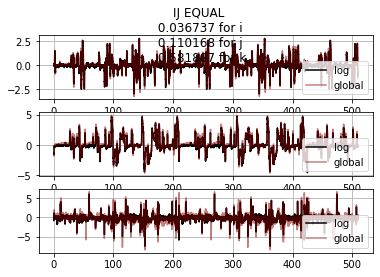

In [26]:

# %%% Comparison a i j k ij equal
Y=compute_acc_global(ct1_global,ct2_global,ch1_global,ch2_global,di_global,dj_global,dk_global)

f=plt.figure()
ax=f.add_subplot(3,1,1)
ax.plot(prep_data["t"],prep_data['acc_body_grad[0]'],color="black",label="log")
ax.plot(prep_data["t"],Y[:,0],color="darkred",label="global",alpha=0.5)
ax.legend(),ax.grid()

ax=f.add_subplot(3,1,2)
ax.plot(prep_data["t"],prep_data['acc_body_grad[1]'],color="black",label="log")
ax.plot(prep_data["t"],Y[:,1],color="darkred",label="global",alpha=0.5)
ax.legend(),ax.grid()

ax=f.add_subplot(3,1,3)
ax.plot(prep_data["t"],prep_data['acc_body_grad[2]'],color="black",label="log")
ax.plot(prep_data["t"],Y[:,2],color="darkred",label="global",alpha=0.5)
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
c_i_=np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2,axis=0)
c_j_=np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2,axis=0)  
c_k_=np.mean((Y[:,2]-prep_data['acc_body_grad[2]'])**2,axis=0)  


s="IJ EQUAL \n %f for i \n %f for j \n %f for k"%(c_i_,c_j_,c_k_)
f.suptitle(s)
print(s)




In [27]:


# %% WITH WIND 



def compute_acc_global_wind(ct1,ct2,ch1,ch2,di=0,dj=0,dk=0,df=prep_data,vwi=0,vwj=0):

    q0,q1,q2,q3=(prep_data['q[0]'],prep_data['q[1]'],
                 prep_data['q[2]'],prep_data['q[3]'])
    
    "precomputing transposition"
    R_transpose=np.array([tf3d.quaternions.quat2mat([i,j,k,l]).T for i,j,k,l in zip(q0,q1,q2,q3)])
    
    vw_earth=np.array([vwi,vwj,0])
    vw_body=R_transpose@vw_earth
    
    
    vai=df["speed_body[0]"]-vw_body[:,0]
    vaj=df["speed_body[1]"]-vw_body[:,1]
    vak=df["speed_body[2]"]-vw_body[:,2]
    
    gammai=df["gamma[0]"]
    gammaj=df["gamma[1]"]
    gammak=df["gamma[2]"]
    
    T=sum([compute_single_motor_thrust_MT(ct1,vak,df['omega_c[%i]'%(i+1)],ct2) for i in range(6)])
    H=sum([compute_H(vak,df['omega_c[%i]'%(i+1)],ch1,ch2) for i in range(6)])
    
    H_vect=np.c_[-vai*H,-vaj*H,np.zeros(H.shape)]
    T_vect=np.c_[np.zeros(T.shape),np.zeros(T.shape),T]
    absva=np.sqrt(vai**2+vaj**2+vak**2)
    Fa=-rho0*Area*np.c_[di*absva*vai,dj*absva*vaj,dk*absva*vak]

    return -T_vect/mass+H_vect+np.c_[gammai,gammaj,gammak]+Fa


def cost_global_dij_wind_(X):
    ct1,ct2,ch1,ch2,dij,dk,vwi,vwj=X

    Y=compute_acc_global_wind(ct1,ct2,ch1,ch2,dij,dij,dk,vwi=vwi,vwj=vwj)

    ci=np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2/max(abs(prep_data['acc_body_grad[0]']))**2,axis=0)
    cj=np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2/max(abs(prep_data['acc_body_grad[1]']))**2,axis=0)
    ck=np.mean((Y[:,2]-prep_data['acc_body_grad[2]'])**2/max(abs(prep_data['acc_body_grad[2]']))**2,axis=0)
    
    c=ci+cj+ck

    print("ct1 :%f, ct2 :%f , ch1 :%f , ch2 :%f , di :%f , dj : %f , dk : %f , vwi : %f ,vwj : %f cost :%f"%(ct1,ct2,ch1,ch2,dij,dij,dk,vwi,vwj,c))

    return c


X0_global_dij_wind_=np.zeros(8)

sol_global_dij_wind_=minimize(cost_global_dij_wind_,X0_global_dij_wind_,method="SLSQP")
ct1_global,ct2_global,ch1_global,ch2_global,di_global,dk_global,vwi_global_,vwj_global_=sol_global_dij_wind_['x']
dj_global=di_global


ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , vwi : 0.000000 ,vwj : 0.000000 cost :1.768746
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , vwi : 0.000000 ,vwj : 0.000000 cost :1.768741
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , vwi : 0.000000 ,vwj : 0.000000 cost :1.768746
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , vwi : 0.000000 ,vwj : 0.000000 cost :1.768746
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , vwi : 0.000000 ,vwj : 0.000000 cost :1.768746
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , vwi : 0.000000 ,vwj : 0.000000 cost :1.768746
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , d


Performances: 
RMS error on acc pred is : 
WIND 
 0.125652 for i 
 0.167381 for j 
 0.539664 for k


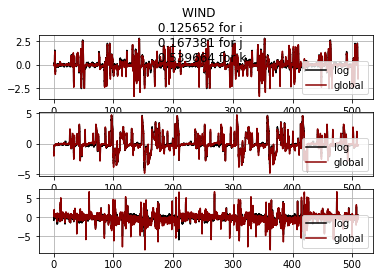

In [28]:
# % Comparison

Y=compute_acc_global_wind(ct1_global,ct2_global,ch1_global,ch2_global,di_global,dj_global,dk_global,vwi=vwi_global_,vwj=vwj_global_)



f=plt.figure()
ax=f.add_subplot(3,1,1)
ax.plot(prep_data["t"],prep_data['acc_body_grad[0]'],color="black",label="log")
ax.plot(prep_data["t"],Y[:,0],color="darkred",label="global")
ax.legend(),ax.grid()

ax=f.add_subplot(3,1,2)
ax.plot(prep_data["t"],prep_data['acc_body_grad[1]'],color="black",label="log")
ax.plot(prep_data["t"],Y[:,1],color="darkred",label="global")
ax.legend(),ax.grid()

ax=f.add_subplot(3,1,3)
ax.plot(prep_data["t"],prep_data['acc_body_grad[2]'],color="black",label="log")
ax.plot(prep_data["t"],Y[:,2],color="darkred",label="global")
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
# c_i_=np.sqrt(np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2,axis=0))
# c_j_=np.sqrt(np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2,axis=0)  )
# c_k_=np.sqrt(np.mean((Y[:,2]-prep_data['acc_body_grad[2]'])**2,axis=0)  )

c_i_=np.mean(np.abs(Y[:,0]-prep_data['acc_body_grad[0]']),axis=0)
c_j_=np.mean(np.abs(Y[:,1]-prep_data['acc_body_grad[1]']),axis=0)  
c_k_=np.mean(np.abs(Y[:,2]-prep_data['acc_body_grad[2]']),axis=0)  
s="WIND \n %f for i \n %f for j \n %f for k"%(c_i_,c_j_,c_k_)
f.suptitle(s)
print(s)



In [37]:





# %% Synthesis


bilan=pd.DataFrame(data=None,
                    columns=['ct1','ct2',
                            'ch1','ch2',
                            'di','dj','dk','vwi','vwj',
                            'cost'],
                    index=['vanilla','custom',
                          'vanilla_dk','custom_with_dk',
                          'ai_drag','ai_h','ai_drag_and_h',
                          'aj_drag','aj_h','aj_drag_and_h',
                          'aij_h','aij_h_and_drag',
                          'aij_h_drag_equal_coeffs',
                          "global","global_equal_coeffs","global_wind"])




bilan.loc["vanilla"]['ct1','cost']=np.r_[sol_vanilla['x'],np.sqrt(sol_vanilla['fun'])]
bilan.loc["custom"]['ct1','ct2','cost']=np.r_[sol_custom['x'],np.sqrt(sol_custom['fun'])]

bilan.loc["vanilla_dk"]['ct1','dk','cost']=np.r_[sol_vanilla_drag['x'],np.sqrt(sol_vanilla_drag['fun'])]
bilan.loc["custom_with_dk"]['ct1','ct2','dk','cost']=np.r_[sol_custom_drag['x'],np.sqrt(sol_custom_drag['fun'])]

bilan.loc['ai_drag']['di','cost']=np.r_[sol_ai_od['x'],sol_ai_od['fun']]
bilan.loc['ai_h']['ch1','ch2','cost']=np.r_[sol_ai_oh['x'],sol_ai_oh['fun']]
bilan.loc['ai_drag_and_h']['ch1','ch2','di','cost']=np.r_[sol_ai_hwd['x'],sol_ai_hwd['fun']]

bilan.loc['aj_drag']['dj','cost']=np.r_[sol_aj_od['x'],sol_aj_od['fun']]
bilan.loc['aj_h']['ch1','ch2','cost']=np.r_[sol_aj_oh['x'],sol_aj_oh['fun']]
bilan.loc['aj_drag_and_h']['ch1','ch2','dj','cost']=np.r_[sol_aj_hwd['x'],sol_aj_hwd['fun']]


bilan.loc['aij_h']['ch1','ch2','cost']=np.r_[sol_aij_nodrag['x'],sol_aij_nodrag['fun']]
bilan.loc['aij_h_and_drag']['ch1','ch2','di','dj','cost']=np.r_[sol_aij_hwd['x'],sol_aij_hwd['fun']]

bilan.loc['aij_h_drag_equal_coeffs']['ch1','ch2','di','cost']=np.r_[sol_aij_hwd_di_eq_dj_['x'],sol_aij_hwd_di_eq_dj_['fun']]
bilan.loc['aij_h_drag_equal_coeffs']['dj']=bilan.loc['aij_h_drag_equal_coeffs']['di']

bilan.loc['global']['ct1','ct2',
                    'ch1','ch2',
                    'di','dj','dk',
                    'cost']=np.r_[sol_global_['x'],sol_global_['fun']]

bilan.loc['global_equal_coeffs']['ct1','ct2',
                    'ch1','ch2',
                    'di','dk',
                    'cost']=np.r_[sol_global_dij_['x'],sol_global_dij_['fun']]

bilan.loc['global_equal_coeffs']["dj"]=bilan.loc['global_equal_coeffs']["di"]

bilan.loc['global_wind']['ct1','ct2',
                    'ch1','ch2',
                    'di','dk','vwi','vwj',
                    'cost']=np.r_[sol_global_dij_wind_['x'],sol_global_dij_wind_['fun']]
bilan.loc['global_wind']["dj"]=bilan.loc['global_wind']["di"]




print(bilan)




                              ct1       ct2       ch1       ch2        di  \
vanilla                  0.010693       NaN       NaN       NaN       NaN   
custom                   0.019165  0.111517       NaN       NaN       NaN   
vanilla_dk                0.01092       NaN       NaN       NaN       NaN   
custom_with_dk           0.013792  0.038738       NaN       NaN       NaN   
ai_drag                       NaN       NaN       NaN       NaN  0.526284   
ai_h                          NaN       NaN  0.005908 -0.075272       NaN   
ai_drag_and_h                 NaN       NaN   0.00346 -0.067663  0.925967   
aj_drag                       NaN       NaN       NaN       NaN       NaN   
aj_h                          NaN       NaN  0.001705 -0.107859       NaN   
aj_drag_and_h                 NaN       NaN  0.000928 -0.103742       NaN   
aij_h                         NaN       NaN  0.002202 -0.103255       NaN   
aij_h_and_drag                NaN       NaN  0.001014 -0.102352  0.854944   